In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name

conf = (SparkConf().setMaster("k8s://https://192.168.219.100:6443") # Your master address name
        .set("spark.kubernetes.container.image", "joron1827/pyspark:v2") # Spark image name
        .set("spark.driver.port", "2222") # Needs to match svc
        .set("spark.driver.blockManager.port", "7777")
        .set("spark.driver.host", "driver-service.jupyterhub.svc.cluster.local") # Needs to match svc
        .set("spark.driver.bindAddress", "0.0.0.0")
        .set("spark.kubernetes.namespace", "spark")
        .set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
        .set("spark.kubernetes.authenticate.serviceAccountName", "spark")
        .set("spark.executor.instances", "4")
        .set("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
        .set("spark.app.name", "joronSpark")
        .set("spark.executor.cores", "4")
        .set("spark.executor.memory", "16g"))

In [2]:

spark = SparkSession.builder.config(conf=conf).getOrCreate()

import time

time.sleep(10)

/home/jovyan/.local/lib/python3.9/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found


23/06/04 12:14:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
save_path = "hdfs://192.168.219.121:9000/crawling_stock_text_merge/text_tokens_label.parquet"

tokenized_df = spark.read.parquet(save_path)
tokenized_df.show()

+------+----------+------------------------------------+----------+----------------------------+
|  code|      date|                               title|New_Column|                      tokens|
+------+----------+------------------------------------+----------+----------------------------+
|005930|2023-04-06|                              여러분|         1|                          []|
|005930|2023-04-06|      나라가  공매도  개망조 들었다 |         1|[나라, 공매도, 개, 망조, ...|
|005930|2023-04-06|       삼성전자 직원 분의  감축 단행|         1|[삼성, 직원, 분, 감축, 단행]|
|005930|2023-04-06|                    분위기 좋고 좋고|         1|        [분위기, 좋고, 좋고]|
|005930|2023-04-06|        삼성전자는 허구한날 왜이래요|         1|  [성, 는, 허구, 한, 날, 요]|
|005930|2023-04-06|                         공매도 전자|         1|                    [공매도]|
|005930|2023-04-06|외국인 선물매도 조 넘은거 처음보는데|         1|[외국인, 선물, 매도, 조, ...|
|005930|2023-04-06|                    순종 못해 망했다|         1|      [순종, 못, 해, 망했다]|
|005930|2023-04-06|                      삼성전자 분기 |       

In [4]:
from pyspark.sql.functions import when

# New_Column 값이 1인 행을 제외하고, 0과 2인 값을 가진 행을 선택하여 새로운 DataFrame 생성
tokenized_df = tokenized_df.filter((tokenized_df.New_Column == 0) | (tokenized_df.New_Column == 2))

# New_Column 값이 2인 경우 1로 변경
tokenized_df = tokenized_df.withColumn("New_Column", when(tokenized_df.New_Column == 2, 1).otherwise(tokenized_df.New_Column))
tokenized_df.show()

+------+----------+------------------------------------+----------+------------------------------+
|  code|      date|                               title|New_Column|                        tokens|
+------+----------+------------------------------------+----------+------------------------------+
|015760|2022-05-30|    이리저리 아무리 생각을 해 보아도|         1|[이리저리, 아무리, 생각, 해...|
|015760|2022-05-30|    이리저리 아무리 생각을 해 보아도|         1|[이리저리, 아무리, 생각, 해...|
|015760|2022-05-30|                  최순실때 만 갔으니|         1|    [최, 순, 실때, 만, 갔으니]|
|015760|2022-05-30|어디에도 전기요금 동결 이야기 없는데|         1|[에도, 전기요금, 동결, 이야...|
|015760|2022-05-30|                    매출은 오르는데 |         1|          [매출, 은, 오르는데]|
|015760|2022-05-30|                         당분간 하락|         1|                [당분간, 하락]|
|015760|2022-05-30|         죄인이처럼 나라 망치지 말자|         1|  [죄인, 처럼, 나라, 망치, ...|
|015760|2022-05-30|              공매도 배 증가전날대비|         1|[공매도, 배, 증가, 전날, 대비]|
|015760|2022-05-30|                   오늘 용돈 받았다 |         1|     

+------+------+
|code  |count |
+------+------+
|008930|34078 |
|074610|177066|
|100090|27385 |
|011690|11710 |
|011930|99120 |
|009830|165706|
|000020|80445 |
|010820|54389 |
|013570|10990 |
|002630|42588 |
|006980|21811 |
|033250|26475 |
|006380|10077 |
|336370|17547 |
|001060|26895 |
|012690|51741 |
|000520|23097 |
|019170|931209|
|001360|127742|
|001440|153849|
+------+------+
only showing top 20 rows



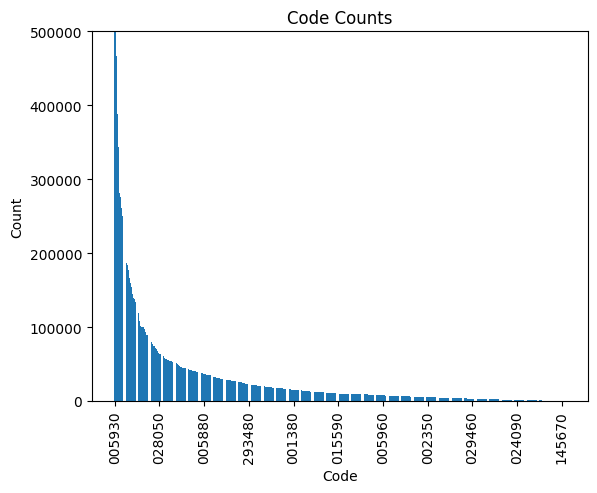

In [10]:
from pyspark.sql.functions import count

# 코드별로 행의 개수 세기
code_counts = tokenized_df.groupBy('code').agg(count('*').alias('count'))

# 결과 출력
code_counts.show(truncate=False)

code_counts_pandas = code_counts.toPandas()


import matplotlib.pyplot as plt

# 내림차순으로 정렬
sorted_code_counts = code_counts_pandas.sort_values('count', ascending=False)

# 히스토그램 그리기
plt.bar(sorted_code_counts['code'], sorted_code_counts['count'])
plt.xlabel('Code')
plt.ylabel('Count')
plt.title('Code Counts')

# x축 레이블 설정
num_ticks = 10  # 표기할 x축 레이블 개수
step = len(sorted_code_counts) // num_ticks
x_ticks = sorted_code_counts.iloc[::step]['code']  # 일정 간격으로 x축 레이블 선택
plt.xticks(x_ticks, rotation=90)

# y축 범위 설정
max_count = sorted_code_counts['count'].max()  # 최대 count 값
plt.ylim(0, 500000)  # 0부터 최대 count 값까지의 범위로 설정

plt.show()


In [7]:
from pyspark.sql.functions import col, row_number
from pyspark.sql import Window

# 라벨 컬럼의 이름
label_column = "New_Column"

# 코드별 데이터 개수 확인
code_counts = tokenized_df.groupBy("code").count()

# 최소 데이터 개수 확인
min_count = code_counts.agg({"count": "min"}).collect()[0][0]
target_count = min_count * 200    # 최소 개수의 절반을 유지하고자 함

# 최소 개수의 절반 이상을 유지하도록 샘플링
window_spec = Window.partitionBy("code").orderBy("date")  # date 컬럼을 기준으로 정렬
balanced_df = tokenized_df.withColumn("row_num", row_number().over(window_spec)).where(col("row_num") <= target_count).drop("row_num")

# 각 코드별로 샘플링된 데이터 개수 확인
balanced_counts = balanced_df.groupBy(label_column).count().collect()

# 결과 출력
for row in balanced_counts:
    label = row[label_column]
    count = row["count"]
    print(f"Label: {label}, Count: {count}")

    
from pyspark.sql.functions import count

# 코드별로 행의 개수 세기
code_counts = balanced_df.groupBy('code').agg(count('*').alias('count'))

# 결과 출력
code_counts.show(truncate=False)



Label: 1, Count: 92779
Label: 0, Count: 51847


+------+-----+
|code  |count|
+------+-----+
|000020|200  |
|000040|200  |
|000050|49   |
|000070|131  |
|000075|5    |
|000080|200  |
|000087|14   |
|000100|200  |
|000105|113  |
|000120|193  |
|000140|33   |
|000145|200  |
|000150|200  |
|000155|200  |
|000157|50   |
|000180|175  |
|000210|200  |
|000215|40   |
|000220|200  |
|000225|200  |
+------+-----+
only showing top 20 rows



In [8]:
from pyspark.sql.functions import col

# 코드 알려주시면 코드에 맞게 조정 가능합니다.
code_column = "code"
label_column = "New_Column"

# 라벨별로 데이터 개수를 확인합니다.
label_counts = balanced_df.groupBy(label_column).count().collect()
label_counts = {row[label_column]: row["count"] for row in label_counts}

# 가장 적은 개수의 데이터를 기준으로 샘플링 비율을 설정합니다.
min_count = min(label_counts.values())
sampling_rates = {label: min_count / count for label, count in label_counts.items()}

# 샘플링 비율을 기준으로 데이터를 샘플링합니다.
sampled_df = balanced_df.sampleBy(label_column, fractions=sampling_rates, seed=42)

# 샘플링된 데이터를 확인합니다.
sampled_df.show()


from pyspark.sql.functions import col

# 라벨 컬럼의 이름
label_column = "New_Column"

# 각 라벨별로 샘플링된 데이터 개수를 확인
sampled_counts = sampled_df.groupBy(label_column).count().collect()

# 결과 출력
for row in sampled_counts:
    label = row[label_column]
    count = row["count"]
    print(f"Label: {label}, Count: {count}")

+------+----------+--------------------------------------+----------+------------------------------+
|  code|      date|                                 title|New_Column|                        tokens|
+------+----------+--------------------------------------+----------+------------------------------+
|000020|2017-06-09|                          이게 뭡니까 |         1|                [게, 뭡, 니까]|
|000020|2017-09-01|                           불개미 비상|         1|                [불개미, 비상]|
|000020|2017-11-23|                                  나도|         1|                        [나도]|
|000020|2017-11-23|                  지금 다 파시는분들은|         1|  [지금, 다, 파시, 는, 분, 은]|
|000020|2017-11-23|                   기간조정 구간입니다|         1|    [기간, 조정, 구간, 입니다]|
|000020|2017-12-13|                    징글징글허다  동화|         0|        [징글징글, 허다, 동화]|
|000020|2017-12-26|                    애처롭기 짝이 없군|         0|          [애처롭기, 짝, 없군]|
|000020|2018-05-14|         이회사는 이사 수집이 취미인가|         0|  [회사, 는, 이사, 수집, 취...|

Label: 1, Count: 51992
Label: 0, Count: 51847


In [9]:
from pyspark.sql.functions import count

# 코드별로 행의 개수 세기
code_counts = sampled_df.groupBy('code').agg(count('*').alias('count'))

# 결과 출력
code_counts.show(truncate=False)

+------+-----+
|code  |count|
+------+-----+
|000020|123  |
|000040|146  |
|000050|36   |
|000070|102  |
|000075|2    |
|000080|160  |
|000087|9    |
|000100|152  |
|000105|62   |
|000120|174  |
|000140|22   |
|000145|118  |
|000150|166  |
|000155|118  |
|000157|40   |
|000180|137  |
|000210|123  |
|000215|23   |
|000220|126  |
|000225|107  |
+------+-----+
only showing top 20 rows



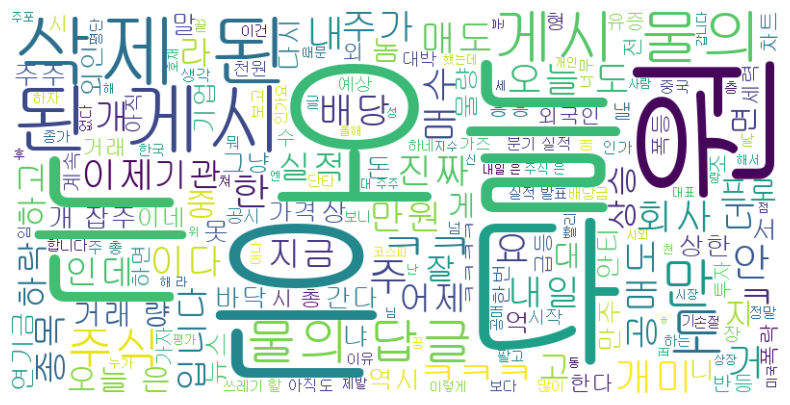

In [10]:
"/home/jovyan/"

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager

# 한글 폰트 경로 및 이름 지정
font_path = "/home/jovyan/gulim.ttc" # 실제 폰트 파일의 경로로 수정
font_name = "gulim.ttc"  # 설치된 폰트의 이름으로 수정

# WordCloud에 한글 폰트 적용
font_manager.fontManager.addfont(font_path)
plt.rcParams["font.family"] = font_name


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import collect_list

# 데이터프레임에서 문자열 컬럼 추출
text_data = sampled_df.filter(sampled_df.New_Column == 0).select("tokens").rdd.flatMap(lambda x: x[0]).collect()

# 문자열 데이터를 공백으로 결합하여 단일 문자열 생성
text = " ".join(text_data)

# WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate(text)

# WordCloud를 plot으로 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

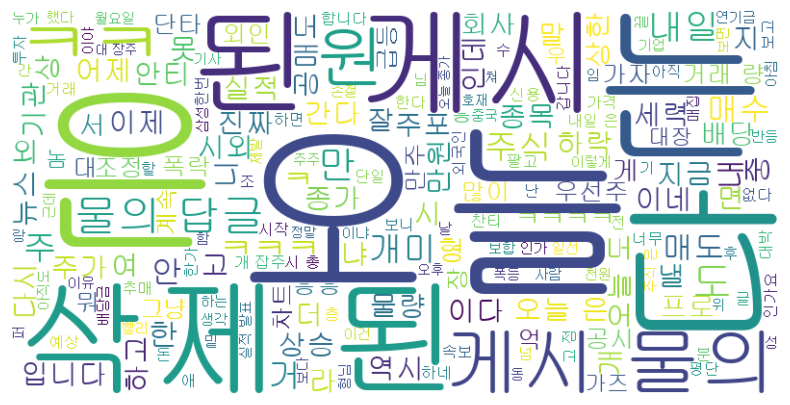

In [11]:
"/home/jovyan/"

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager

# 한글 폰트 경로 및 이름 지정
font_path = "/home/jovyan/gulim.ttc" # 실제 폰트 파일의 경로로 수정
font_name = "gulim.ttc"  # 설치된 폰트의 이름으로 수정

# WordCloud에 한글 폰트 적용
font_manager.fontManager.addfont(font_path)
plt.rcParams["font.family"] = font_name


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import collect_list

# 데이터프레임에서 문자열 컬럼 추출
text_data = sampled_df.filter(sampled_df.New_Column == 1).select("tokens").rdd.flatMap(lambda x: x[0]).collect()

# 문자열 데이터를 공백으로 결합하여 단일 문자열 생성
text = " ".join(text_data)

# WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate(text)

# WordCloud를 plot으로 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
## 중복열 제거
## 최빈도 단어 제거
## tfidf 만약 max_df와 같은 기능을 적용하고 싶다면, 스파크에서 직접 해당 기능을 구현해야 합니다. 
## 예를 들어, pyspark.ml.feature.CountVectorizer를 사용하여 단어의 빈도를 계산한 다음, 
## 해당 단어의 빈도가 일정 값 이상인 경우 필터링하는 작업을 추가할 수 있습니다. 이후에 IDF를 적용하여 역문서 빈도를 계산합니다.
## null 값 제거
## 로지스틱, 의사결정트리, SVM, 랜덤포레스트, multinomial NB 

In [5]:
from pyspark.sql.functions import explode, col, array_except, array, lit, udf
from pyspark.sql.types import ArrayType, StringType

# 단어별 빈도수 계산
word_counts = tokenized_df.select(explode('tokens').alias('word')).groupBy('word').count()

# 빈도수로 내림차순 정렬하여 상위 30개 단어 추출
top_words = word_counts.orderBy(col('count').desc()).limit(30)

# 상위 30개 단어 리스트 추출
top_words_list = [row.word for row in top_words.collect()]

print(top_words_list)
# Define the UDF to filter out words in top_words_list
filter_words = udf(lambda tokens: [word for word in tokens if word not in top_words_list], ArrayType(StringType()))

# Add a new column 'filtered_tokens' with only the words present in top_words_list
filtered_df = tokenized_df.withColumn('filtered_tokens', filter_words(col('tokens')))

filtered_df.show()

['은', '오늘', '는', '다', '도', '만', '주', '원', '한', '개미', '매수', '된', '삭제', '게시', '물의', 'ㅋㅋ', '주식', '고', '답글', '안', '라', '개', '내일', '상', '시', '내', '매도', '만원', '대', '이다']


+------+----------+------------------------------------+----------+------------------------------+------------------------------+
|  code|      date|                               title|New_Column|                        tokens|               filtered_tokens|
+------+----------+------------------------------------+----------+------------------------------+------------------------------+
|015760|2022-05-30|    이리저리 아무리 생각을 해 보아도|         1|[이리저리, 아무리, 생각, 해...|[이리저리, 아무리, 생각, 해...|
|015760|2022-05-30|    이리저리 아무리 생각을 해 보아도|         1|[이리저리, 아무리, 생각, 해...|[이리저리, 아무리, 생각, 해...|
|015760|2022-05-30|                  최순실때 만 갔으니|         1|    [최, 순, 실때, 만, 갔으니]|        [최, 순, 실때, 갔으니]|
|015760|2022-05-30|어디에도 전기요금 동결 이야기 없는데|         1|[에도, 전기요금, 동결, 이야...|[에도, 전기요금, 동결, 이야...|
|015760|2022-05-30|                    매출은 오르는데 |         1|          [매출, 은, 오르는데]|              [매출, 오르는데]|
|015760|2022-05-30|                         당분간 하락|         1|                [당분간, 하락]|                [당분

In [8]:
filtered_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- date: date (nullable = true)
 |-- title: string (nullable = true)
 |-- New_Column: integer (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



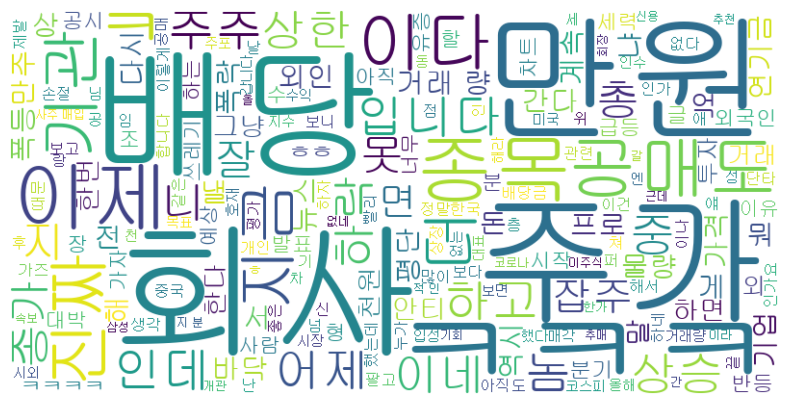

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import font_manager

# 한글 폰트 경로 및 이름 지정
font_path = "/home/jovyan/gulim.ttc" # 실제 폰트 파일의 경로로 수정
font_name = "gulim.ttc"  # 설치된 폰트의 이름으로 수정

# WordCloud에 한글 폰트 적용
font_manager.fontManager.addfont(font_path)
plt.rcParams["font.family"] = font_name


import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import collect_list

# 데이터프레임에서 문자열 컬럼 추출
text_data = filtered_df.filter(filtered_df.New_Column == 0).select("filtered_tokens").rdd.flatMap(lambda x: x[0]).collect()

# 문자열 데이터를 공백으로 결합하여 단일 문자열 생성
text = " ".join(text_data)

# WordCloud 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate(text)

# WordCloud를 plot으로 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
filtered_df = filtered_df.dropDuplicates(["title","tokens"])
filtered_df.show()
filtered_df.count()

+------+----------+-------------------------------+----------+------------------------------+------------------------------+
|  code|      date|                          title|New_Column|                        tokens|               filtered_tokens|
+------+----------+-------------------------------+----------+------------------------------+------------------------------+
|027740|2019-05-07|                         조천억|         1|                      [조천억]|                      [조천억]|
|007160|2017-12-27|                    니   니  니|         0|                  [니, 니, 니]|                  [니, 니, 니]|
|066570|2020-04-13|                           매동|         1|                          [동]|                          [동]|
|028050|2021-09-24|             숨겨놓고 조질나...|         1|  [숨겨놓고, 조질, 나게, 판다]|  [숨겨놓고, 조질, 나게, 판다]|
|026890|2018-10-29|                 공매도취재요청|         1|          [공매도, 취재, 요청]|          [공매도, 취재, 요청]|
|007570|2021-03-11|          문재인 대통령 께서...|         0|[문재인, 대통령, 께서, 수

769381

In [7]:
from pyspark.sql.types import BooleanType


# UDF 정의
def is_empty_string(value):
    return len(value) == 0

# UDF 등록
is_empty_string_udf = udf(is_empty_string, BooleanType())

# filtered_tokens 컬럼의 빈 문자열을 결측치로 간주하여 제거
df_filtered = filtered_df.filter(~is_empty_string_udf(col("filtered_tokens")))

# 결과 출력
df_filtered.show()
df_filtered.count()
df_filtered.printSchema()




+------+----------+-------------------------------+----------+------------------------------+------------------------------+
|  code|      date|                          title|New_Column|                        tokens|               filtered_tokens|
+------+----------+-------------------------------+----------+------------------------------+------------------------------+
|027740|2019-05-07|                         조천억|         1|                      [조천억]|                      [조천억]|
|007160|2017-12-27|                    니   니  니|         0|                  [니, 니, 니]|                  [니, 니, 니]|
|066570|2020-04-13|                           매동|         1|                          [동]|                          [동]|
|028050|2021-09-24|             숨겨놓고 조질나...|         1|  [숨겨놓고, 조질, 나게, 판다]|  [숨겨놓고, 조질, 나게, 판다]|
|026890|2018-10-29|                 공매도취재요청|         1|          [공매도, 취재, 요청]|          [공매도, 취재, 요청]|
|007570|2021-03-11|          문재인 대통령 께서...|         0|[문재인, 대통령, 께서, 수

root
 |-- code: string (nullable = true)
 |-- date: date (nullable = true)
 |-- title: string (nullable = true)
 |-- New_Column: integer (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [8]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline

# TF-IDF 벡터화를 위한 단계
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="tf")
idf = IDF(inputCol="tf", outputCol="tfidf", minDocFreq=3)  # min_df 값 설정

# 파이프라인 구성
pipeline = Pipeline(stages=[hashingTF, idf])

# 데이터 학습 및 변환
model = pipeline.fit(df_filtered)
transformed_data = model.transform(df_filtered)

# 결과 출력
transformed_data.show()



23/06/04 12:16:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
+------+----------+-------------------------------+----------+------------------------------+------------------------------+--------------------+--------------------+
|  code|      date|                          title|New_Column|                        tokens|               filtered_tokens|                  tf|               tfidf|
+------+----------+-------------------------------+----------+------------------------------+------------------------------+--------------------+--------------------+
|027740|2019-05-07|                         조천억|         1|                      [조천억]|                      [조천억]|(262144,[230657],...|(262144,[230657],...|
|007160|2017-12-27|                    니   니  니|         0|                  [니, 니, 니]|                  [니, 니, 니]|(262144,[201984],...|(262144,[201984],...|
|066570|2020-04-13|                           매동|         1|                          [동]|       

In [11]:
from pyspark.sql.functions import rand

transformed_data = transformed_data.select('tfidf').orderBy(rand()).limit(3000)

In [12]:
from pyspark.ml.feature import VectorAssembler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 데이터 전처리 - 벡터화
vectorAssembler = VectorAssembler(inputCols=["tfidf"], outputCol="features")
vectorized_df = vectorAssembler.transform(transformed_data).select("features")

# numpy 배열로 변환
features = np.array(vectorized_df.select("features").rdd.map(lambda x: x[0].toArray()).collect())

# t-SNE를 사용하여 2차원으로 축소
tsne = TSNE(n_components=2, random_state=1)
embedded_vectors = tsne.fit_transform(features)

# 시각화
plt.scatter(embedded_vectors[:, 0], embedded_vectors[:, 1])
plt.title("t-SNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


23/06/04 12:19:30 ERROR TaskSchedulerImpl: Lost executor 13 on 10.244.0.67: 
The executor with id 13 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T21:10:28Z
	 container finished at: 2023-06-04T21:14:47Z
	 exit code: 137
	 termination reason: OOMKilled
      
23/06/04 12:19:30 WARN TaskSetManager: Lost task 5.0 in stage 34.0 (TID 220) (10.244.0.67 executor 13): ExecutorLostFailure (executor 13 exited caused by one of the running tasks) Reason: 
The executor with id 13 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T21:10:28Z
	 container finished a

ERROR:root:KeyboardInterrupt while sending command.                (0 + 0) / 18]
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/jovyan/.local/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/local/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

23/06/04 12:19:53 WARN TaskSetManager: Lost task 12.0 in stage 34.1 (TID 262) (10.244.2.51 executor 20): FetchFailed(null, shuffleId=10, mapIndex=-1, mapId=-1, reduceId=144, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 10 partition 144
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1705)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10(MapOutputTracker.scala:1652)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10$adapted(MapOutputTracker.scala:1651)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1651)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorIdImpl(MapOutputTracker.scala:1294)
	at org.apache.spark.MapOutputTrackerWorker.g

23/06/04 12:19:53 WARN TaskSetManager: Lost task 16.0 in stage 34.1 (TID 266) (10.244.2.51 executor 20): FetchFailed(null, shuffleId=10, mapIndex=-1, mapId=-1, reduceId=192, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 10 partition 192
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1705)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10(MapOutputTracker.scala:1652)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10$adapted(MapOutputTracker.scala:1651)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1651)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorIdImpl(MapOutputTracker.scala:1294)
	at org.apache.spark.MapOutputTrackerWorker.g

23/06/04 12:20:22 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 12:25:37 ERROR TaskSchedulerImpl: Lost executor 14 on 10.244.0.68: 
The executor with id 14 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T21:13:00Z
	 container finished at: 2023-06-04T21:20:55Z
	 exit code: 137
	 termination reason: OOMKilled
      
23/06/04 12:25:37 WARN TaskSetManager: Lost task 4.0 in stage 34.1 (TID 254) (10.244.0.68 executor 14): ExecutorLostFailure (executor 14 exited caused by one of the running tasks) Reason: 
The executor with id 14 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T21:13:00Z
	 container finished a

23/06/04 12:25:53 WARN TaskSetManager: Lost task 5.0 in stage 34.2 (TID 284) (10.244.0.72 executor 23): FetchFailed(null, shuffleId=10, mapIndex=-1, mapId=-1, reduceId=60, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 10 partition 60
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1705)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10(MapOutputTracker.scala:1652)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10$adapted(MapOutputTracker.scala:1651)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1651)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorIdImpl(MapOutputTracker.scala:1294)
	at org.apache.spark.MapOutputTrackerWorker.getM

23/06/04 12:25:54 WARN TaskSetManager: Lost task 8.0 in stage 34.2 (TID 287) (10.244.0.72 executor 23): FetchFailed(null, shuffleId=10, mapIndex=-1, mapId=-1, reduceId=96, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 10 partition 96
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1705)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10(MapOutputTracker.scala:1652)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10$adapted(MapOutputTracker.scala:1651)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1651)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorIdImpl(MapOutputTracker.scala:1294)
	at org.apache.spark.MapOutputTrackerWorker.getM

23/06/04 12:26:06 ERROR TaskSchedulerImpl: Lost executor 20 on 10.244.2.51: 
The executor with id 20 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T12:10:20Z
	 container finished at: 2023-06-04T12:16:36Z
	 exit code: 137
	 termination reason: OOMKilled
      
23/06/04 12:26:06 WARN TaskSetManager: Lost task 1.0 in stage 34.2 (TID 280) (10.244.2.51 executor 20): ExecutorLostFailure (executor 20 exited caused by one of the running tasks) Reason: 
The executor with id 20 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T12:10:20Z
	 container finished a

23/06/04 12:26:27 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 12:26:34 ERROR TaskSchedulerImpl: Lost executor 16 on 10.244.1.153: 
The executor with id 16 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T12:17:59Z
	 container finished at: 2023-06-04T12:26:45Z
	 exit code: 137
	 termination reason: OOMKilled
      
23/06/04 12:26:34 WARN TaskSetManager: Lost task 3.0 in stage 34.1 (TID 253) (10.244.1.153 executor 16): ExecutorLostFailure (executor 16 exited caused by one of the running tasks) Reason: 
The executor with id 16 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T12:17:59Z
	 container finished

23/06/04 12:26:37 ERROR TaskSchedulerImpl: Lost executor 17 on 10.244.1.154: 
The executor with id 17 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T12:18:08Z
	 container finished at: 2023-06-04T12:26:48Z
	 exit code: 137
	 termination reason: OOMKilled
      
23/06/04 12:26:37 WARN TaskSetManager: Lost task 9.0 in stage 34.1 (TID 259) (10.244.1.154 executor 17): ExecutorLostFailure (executor 17 exited caused by one of the running tasks) Reason: 
The executor with id 17 exited with exit code 137(SIGKILL, possible container OOM).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T12:18:08Z
	 container finished

23/06/04 12:27:02 WARN TaskSetManager: Lost task 10.0 in stage 34.3 (TID 325) (10.244.2.53 executor 30): FetchFailed(null, shuffleId=10, mapIndex=-1, mapId=-1, reduceId=120, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 10 partition 120
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1705)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10(MapOutputTracker.scala:1652)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10$adapted(MapOutputTracker.scala:1651)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1651)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorIdImpl(MapOutputTracker.scala:1294)
	at org.apache.spark.MapOutputTrackerWorker.g

23/06/04 12:27:02 WARN TaskSetManager: Lost task 12.0 in stage 34.3 (TID 327) (10.244.2.53 executor 30): FetchFailed(null, shuffleId=10, mapIndex=-1, mapId=-1, reduceId=144, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 10 partition 144
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1705)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10(MapOutputTracker.scala:1652)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$10$adapted(MapOutputTracker.scala:1651)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:1651)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorIdImpl(MapOutputTracker.scala:1294)
	at org.apache.spark.MapOutputTrackerWorker.g

In [42]:
model.save("hdfs://192.168.219.121:9000/crawling_stock_text_merge/hashing_idf_model")

23/06/04 06:55:52 WARN TaskSetManager: Stage 35 contains a task of very large size (4184 KiB). The maximum recommended task size is 1000 KiB.


In [43]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# Logistic Regression
lr = LogisticRegression(labelCol="New_Column", featuresCol="tfidf", threshold=0.5)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_lr = binary_evaluator.evaluate(lr_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_lr = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "accuracy"})
precision_lr = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_lr = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_lr = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("Logistic Regression - AUC:", auc_lr)
print("Logistic Regression - Accuracy:", accuracy_lr)
print("Logistic Regression - Precision:", precision_lr)
print("Logistic Regression - Recall:", recall_lr)
print("Logistic Regression - F1 Score:", f1_score_lr)

lr_model.save("hdfs://192.168.219.121:9000/crawling_stock_text_merge/lr_model")


23/06/04 06:57:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 06:57:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 06:57:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 06:57:26 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 06:57:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:29 WARN DAGScheduler: Broadcasting larg

23/06/04 06:57:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 06:57:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:57:42 WARN DAGScheduler: Broadcasting larg

23/06/04 06:58:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 06:58:09 WARN DAGScheduler: Broadcasting larg

23/06/04 06:58:46 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 06:58:58 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 06:59:11 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 06:59:22 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 06:59:34 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


Logistic Regression - AUC: 0.7010708728897528
Logistic Regression - Accuracy: 0.6943858149595311
Logistic Regression - Precision: 0.614856276886977
Logistic Regression - Recall: 0.3174813357546408
Logistic Regression - F1 Score: 0.6658151691518717


In [44]:
spark.stop()

23/06/04 07:00:37 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.


In [19]:
from pyspark.sql.functions import col

# New_Column과 prediction이 같은 값을 가지는 행 필터링
lr_filtered_data = lr_predictions.filter(col("New_Column") == col("prediction"))

# 필터링된 행의 갯수 계산
count = lr_filtered_data.count()

# 결과 출력
lr_filtered_data.show()
print("Filtered Rows Count:", count)


23/06/04 02:13:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/06/04 02:13:57 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+------+----------+-------------------------------------+----------+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  code|      date|                                title|New_Column|                        tokens|              filtered_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|
+------+----------+-------------------------------------+----------+------------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|000020|2020-06-12|                지금 파는 개미는 뭐지|         1|  [지금, 파는, 개미, 는, 뭐...|         [지금, 파는, 뭐, 지]|(262144,[106330,1...|(262144,[106330,1...|[-0.9883275585881...|[0.27124254268010...|       1.0|
|000020|2020-07-29|                        대박들 나시길|         1|                [대박, 나시길]|               [대박, 나시길]|(262144,[4

In [32]:
import pyspark.sql.functions as F

first_row = lr_predictions.select("title","New_Column","probability","prediction").first()
probability_value = first_row
print(probability_value)

23/06/04 02:27:27 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
Row(title='근데 동화약품 부채표 마스크는', New_Column=0, probability=DenseVector([0.2183, 0.7817]), prediction=1.0)


In [10]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# Random Forest
rf = RandomForestClassifier(labelCol="New_Column", featuresCol="tfidf")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_rf = binary_evaluator.evaluate(rf_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_rf = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "accuracy"})
precision_rf = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_rf = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_rf = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("Random Forest - AUC:", auc_rf)
print("Random Forest - Accuracy:", accuracy_rf)
print("Random Forest - Precision:", precision_rf)
print("Random Forest - Recall:", recall_rf)
print("Random Forest - F1 Score:", f1_score_rf)

23/06/04 01:34:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:34:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:34:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:34:51 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


23/06/04 01:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


23/06/04 01:35:06 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 01:38:55 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/06/04 01:40:38 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/06/04 01:42:23 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/06/04 01:44:08 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


23/06/04 01:46:23 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/06/04 01:46:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/06/04 01:46:46 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/06/04 01:46:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/06/04 01:47:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Random Forest - AUC: 0.5201668185830378
Random Forest - Accuracy: 0.6548109126430366
Random Forest - Precision: 0.0
Random Forest - Recall: 0.0
Random Forest - F1 Score: 0.5173611280701105


In [22]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# Decision Tree
dt = DecisionTreeClassifier(labelCol="New_Column", featuresCol="tfidf")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_dt = binary_evaluator.evaluate(dt_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_dt = multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "accuracy"})
precision_dt = multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_dt = multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_dt = multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("Decision Tree - AUC:", auc_dt)
print("Decision Tree - Accuracy:", accuracy_dt)
print("Decision Tree - Precision:", precision_dt)
print("Decision Tree - Recall:", recall_dt)
print("Decision Tree - F1 Score:", f1_score_dt)


23/06/04 00:50:47 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:50:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:50:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:50:59 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


23/06/04 00:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


23/06/04 00:51:14 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:52:02 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:52:25 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:52:49 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:53:12 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


23/06/04 00:53:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:53:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:54:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:54:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:54:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
Decision Tree - AUC: 0.5017252840414712
Decision Tree - Accuracy: 0.5057991418610888
Decision Tree - Precision: 0.7615571776155717
Decision Tree - Recall: 0.020928055629847554
Decision Tree - F1 Score: 0.3532147270868981


In [20]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# SVM
svm = LinearSVC(labelCol="New_Column", featuresCol="tfidf")
svm_model = svm.fit(train_data)
svm_predictions = svm_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_svm = binary_evaluator.evaluate(svm_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_svm = multi_evaluator.evaluate(svm_predictions, {multi_evaluator.metricName: "accuracy"})
precision_svm = multi_evaluator.evaluate(svm_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_svm = multi_evaluator.evaluate(svm_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_svm = multi_evaluator.evaluate(svm_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("SVM - AUC:", auc_svm)
print("SVM - Accuracy:", accuracy_svm)
print("SVM - Precision:", precision_svm)
print("SVM - Recall:", recall_svm)
print("SVM - F1 Score:", f1_score_svm)


23/06/04 00:45:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:40 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:41 WARN DAGScheduler: Broadcasting larg

23/06/04 00:45:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:54 WARN DAGScheduler: Broadcasting larg

23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:45:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/04 00:46:01 WARN DAGScheduler: Broadcasting larg

23/06/04 00:47:17 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/04 00:47:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/04 00:47:39 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/04 00:47:51 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/06/04 00:48:02 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


SVM - AUC: 0.6014182571050931
SVM - Accuracy: 0.5732148843446195
SVM - Precision: 0.5795258620689655
SVM - Recall: 0.5394543266015782
SVM - F1 Score: 0.5728820535507173


In [11]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

# NaiveBayes
nb = NaiveBayes(labelCol="New_Column", featuresCol="tfidf")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# Evaluation
binary_evaluator = BinaryClassificationEvaluator(labelCol="New_Column")
auc_nb = binary_evaluator.evaluate(nb_predictions)

multi_evaluator = MulticlassClassificationEvaluator(labelCol="New_Column")
accuracy_nb = multi_evaluator.evaluate(nb_predictions, {multi_evaluator.metricName: "accuracy"})
precision_nb = multi_evaluator.evaluate(nb_predictions, {multi_evaluator.metricName: "precisionByLabel"})
recall_nb = multi_evaluator.evaluate(nb_predictions, {multi_evaluator.metricName: "recallByLabel"})
f1_score_nb = multi_evaluator.evaluate(nb_predictions, {multi_evaluator.metricName: "f1"})

# Print the results
print("NaiveBayes - AUC:", auc_nb)
print("NaiveBayes - Accuracy:", accuracy_nb)
print("NaiveBayes - Precision:", precision_nb)
print("NaiveBayes - Recall:", recall_nb)
print("NaiveBayes - F1 Score:", f1_score_nb)


23/06/04 01:49:31 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:49:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


23/06/04 01:49:43 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/06/04 01:49:53 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/06/04 01:50:05 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/06/04 01:50:18 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/06/04 01:50:28 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


NaiveBayes - AUC: 0.5237183911285037
NaiveBayes - Accuracy: 0.6613522188110522
NaiveBayes - Precision: 0.5101899449487769
NaiveBayes - Recall: 0.5283852162172393
NaiveBayes - F1 Score: 0.6623427509329021


In [17]:
nb_predictions.show()

23/06/04 02:01:44 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
+------+----------+-------------------------------------+----------+------------------------------+------------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  code|      date|                                title|New_Column|                        tokens|               filtered_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|
+------+----------+-------------------------------------+----------+------------------------------+------------------------------+--------------------+--------------------+--------------------+--------------------+----------+
|000020|2020-04-29|    연휴중  치료목적 응급임상승인 ...|         1|  [연휴, 중, 치료, 목적, 응...|  [연휴, 중, 치료, 목적, 응...|(262144,[26959,85...|(262144,[26959,85...|[-595.26066104592...|[6.00232519820964...|       1.0|
|000020|2020-07-29|   달넘게 있었던 사람으로서 말하자

In [24]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# VectorAssembler를 사용하여 필요한 열을 feature vector로 변환
vectorAssembler = VectorAssembler(inputCols=["tfidf"], outputCol="features")
data = vectorAssembler.transform(transformed_data)

# KMeans 알고리즘을 사용하여 클러스터링 모델 생성
kmeans = KMeans(k=5, seed=42)
model = kmeans.fit(data)

# 클러스터링 결과를 예측
predictions = model.transform(data)

# 예측 결과 확인
predictions.select("title", "prediction").show()

23/06/04 00:59:52 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 00:59:53 WARN TaskSetManager: Lost task 10.0 in stage 1581.0 (TID 11966) (10.244.1.60 executor 15): org.apache.spark.SparkException: Can only zip RDDs with same number of elements in each partition
	at org.apache.spark.errors.SparkCoreErrors$.canOnlyZipRDDsWithSamePartitionSizeError(SparkCoreErrors.scala:115)
	at org.apache.spark.rdd.RDD$$anon$3.hasNext(RDD.scala:946)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1518)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1445)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1509)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1332)
	at org.apa

23/06/04 00:59:56 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 00:59:58 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:00 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:02 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:04 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:06 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:08 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:09 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:11 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:13 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:15 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:17 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


23/06/04 01:00:25 WARN DAGScheduler: Broadcasting large task binary with size 28.0 MiB


23/06/04 01:00:28 WARN DAGScheduler: Broadcasting large task binary with size 28.0 MiB


AnalysisException: Column 'predictions' does not exist. Did you mean one of the following? [prediction, features, code, date, title, tokens, New_Column, filtered_tokens, tf, tfidf];
'Project [title#2, 'predictions]
+- Project [code#0, date#1, title#2, New_Column#32, tokens#4, filtered_tokens#211, tf#302, tfidf#313, features#1442, UDF(features#1442) AS prediction#1496]
   +- Project [code#0, date#1, title#2, New_Column#32, tokens#4, filtered_tokens#211, tf#302, tfidf#313, UDF(struct(tfidf, tfidf#313)) AS features#1442]
      +- Project [code#0, date#1, title#2, New_Column#32, tokens#4, filtered_tokens#211, tf#302, UDF(tf#302) AS tfidf#313]
         +- Project [code#0, date#1, title#2, New_Column#32, tokens#4, filtered_tokens#211, UDF(filtered_tokens#211) AS tf#302]
            +- Filter NOT is_empty_string(filtered_tokens#211)#246
               +- Project [code#0, date#1, title#2, New_Column#32, tokens#4, <lambda>(tokens#4)#210 AS filtered_tokens#211]
                  +- Filter UDF(New_Column#32, rand(42))
                     +- Project [code#0, date#1, title#2, New_Column#32, tokens#4]
                        +- Filter (row_num#81 <= 200)
                           +- Project [code#0, date#1, title#2, New_Column#32, tokens#4, row_num#81]
                              +- Project [code#0, date#1, title#2, New_Column#32, tokens#4, row_num#81, row_num#81]
                                 +- Window [row_number() windowspecdefinition(code#0, date#1 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS row_num#81], [code#0], [date#1 ASC NULLS FIRST]
                                    +- Project [code#0, date#1, title#2, New_Column#32, tokens#4]
                                       +- Project [code#0, date#1, title#2, CASE WHEN (New_Column#3 = 2) THEN 1 ELSE New_Column#3 END AS New_Column#32, tokens#4]
                                          +- Filter ((New_Column#3 = 0) OR (New_Column#3 = 2))
                                             +- Filter ((New_Column#3 = 0) OR (New_Column#3 = 2))
                                                +- Relation [code#0,date#1,title#2,New_Column#3,tokens#4] parquet


In [26]:
# 예측 결과 확인
predictions.select("title", "prediction","New_Column").show()

23/06/04 01:01:57 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
+--------------------------------------+----------+----------+
|                                 title|prediction|New_Column|
+--------------------------------------+----------+----------+
|                          이게 뭡니까 |         0|         1|
|                           불개미 비상|         0|         1|
|                                  나도|         0|         1|
|                  지금 다 파시는분들은|         0|         1|
|                   기간조정 구간입니다|         0|         1|
|                    징글징글허다  동화|         0|         0|
|                    애처롭기 짝이 없군|         0|         0|
|         이회사는 이사 수집이 취미인가|         0|         0|
|                       실적 올라왔네요|         0|         0|
|                                동화사|         0|         0|
|                        원 위대함 시작|         3|         0|
|        아파트대출 주식투자자들 어쩌나|         0|         0|
|                          내가예언하지|         0|         0|


In [8]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.linalg import VectorUDT, Vectors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pyspark.sql.functions import rand


In [10]:
from pyspark.sql.functions import rand

sampled_df = df_filtered.select('filtered_tokens').orderBy(rand()).limit(3000)


In [11]:
vectorizer = CountVectorizer(inputCol='filtered_tokens', outputCol='raw_features')
idf = IDF(inputCol='raw_features', outputCol='features')


In [12]:
num_clusters = 5
kmeans = KMeans(k=num_clusters, seed=1)


In [15]:
pipeline = Pipeline(stages=[vectorizer, idf, kmeans])
model = pipeline.fit(sampled_df)
clustered_df = model.transform(sampled_df)


23/06/04 11:42:35 ERROR TaskSchedulerImpl: Lost executor 2 on 10.244.1.139: 
The executor with id 2 exited with exit code 134(unexpected).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T11:36:54Z
	 container finished at: 2023-06-04T11:42:46Z
	 exit code: 134
	 termination reason: Error
      
23/06/04 11:42:35 WARN TaskSetManager: Lost task 3.0 in stage 119.0 (TID 458) (10.244.1.139 executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: 
The executor with id 2 exited with exit code 134(unexpected).



The API gave the following container statuses:


	 container name: spark-kubernetes-executor
	 container image: docker.io/joron1827/pyspark:v2
	 container state: terminated
	 container started at: 2023-06-04T11:36:54Z
	 container finished at: 2023-06-04T11:42:46Z
	 exit code: 134
	 termi

In [17]:
import numpy as np

vectors = np.array(clustered_df.select('features').rdd.map(lambda x: x[0].toArray()).collect())
tsne = TSNE(n_components=2, random_state=1)
embedded_vectors = tsne.fit_transform(vectors)


In [18]:
clustered_df = clustered_df.withColumn('cluster', clustered_df['prediction'].cast('string'))
embedded_df = spark.createDataFrame(zip(embedded_vectors.tolist(), clustered_df.select('cluster').rdd.map(lambda x: x[0]).collect()), ['embedding', 'cluster'])


findfont: Font family 'gulim.ttc' not found.                                    
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font family 'gulim.ttc' not found.
findfont: Font fami

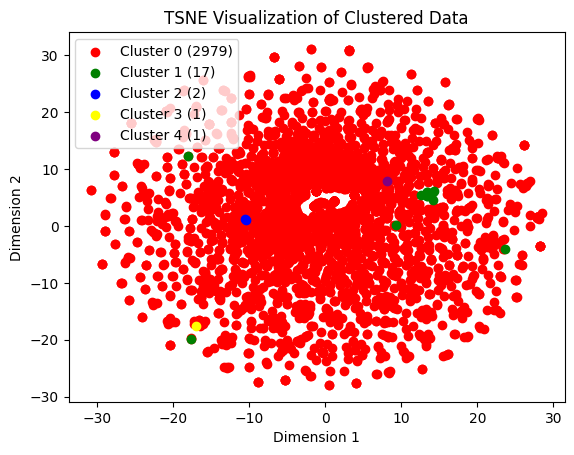

In [54]:
# 각 클러스터의 데이터 수 세기
cluster_counts = embedded_df.groupBy('cluster').count().orderBy('cluster')

# 각 클러스터의 데이터 시각화
colors = ['red', 'green', 'blue', 'yellow', 'purple']  # 클러스터별 색상 지정
for row in cluster_counts.collect():
    cluster = int(row['cluster'])  # 문자열을 정수형으로 변환
    count = row['count']
    embedding = embedded_df.filter(embedded_df['cluster'] == cluster).select('embedding').rdd.map(lambda x: x[0]).collect()
    plt.scatter([e[0] for e in embedding], [e[1] for e in embedding], c=colors[cluster], label=f'Cluster {cluster} ({count})')

plt.title('TSNE Visualization of Clustered Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


In [50]:
from pyspark.ml.feature import IDF

representative_words = []
for cluster in range(num_clusters):
    words = model.stages[0].vocabulary
    centroids = model.stages[2].clusterCenters()

    # Get the centroid vector for the current cluster
    centroid_vector = Vectors.dense(centroids[cluster])

    # Convert centroid_vector to Python list
    centroid_list = centroid_vector.toArray().tolist()

    # Create a Row object with centroid list
    centroid_row = Row(features=centroid_list)

    # Create a DataFrame with the centroid row
    centroid_df = spark.createDataFrame([centroid_row])

    # Apply IDF transformation to centroid_df
    centroid_features = model.stages[1].transform(centroid_df).select("features").first().features.toArray()

    print(f"Centroid Features: {centroid_features}")  # Debugging line
    top_words_idx = centroid_features.argsort()[-num_words:][::-1]
    top_words = [words[i] for i in top_words_idx]
    representative_words.append(top_words)


IllegalArgumentException: raw_features does not exist. Available: features

In [13]:
spark.stop()

23/06/04 12:34:21 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
